# Generic analysis with dynamic indicators and stability time

### Execute this cell for better plots

In [1]:
%matplotlib widget

### Libraries

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
from numba import njit, prange

DPI = 600

<ipython-input-2-aa0e6262dfc3>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Directories (local computer)

In [3]:
outdir = "../data"
inputdir = "../data"
imgdir = "../img"

## Directories (SWAN instance + CERNBox file system)

In [4]:
outdir = "../data"
inputdir = "../data"
imgdir = "../img"

## Data Filename list

In [5]:
init_file = "henon_4d_init_eps_0_0_mu_0_0_id_basic_view.hdf5"

displacement_file = "henon_4d_displacement_eps_0_0_mu_0_0_id_basic_view_subid_1e-14.hdf5"
inversion_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_no_kick.hdf5"
inversion_gauss_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_gauss_kick.hdf5"
inversion_uniform_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_unif_kick.hdf5"
inversion_gauss_forward_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_gauss_kick_forward.hdf5"
inversion_uniform_forward_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_unif_kick_forward.hdf5"
tracking_file = "henon_4d_long_track_eps_0_0_mu_0_0_id_basic_view.hdf5"
orto_displacement_file = "henon_4d_orto_displacement_eps_0_0_mu_0_0_id_basic_view_subid_1e-14.hdf5"
full_track_file = "henon_4d_verbose_track_eps_0_0_mu_0_0_id_basic_view.hdf5"
tracking_wkick_file = "henon_4d_long_track_wkick_eps_0_0_mu_0_0_id_basic_view_subid_1e-8.hdf5"
tracking_wkick_file2 = "henon_4d_long_track_wkick_eps_0_0_mu_0_0_id_basic_view_subid_1e-12.hdf5"
megno_file = "henon_4d_megno_eps_0_0_mu_0_0_id_basic_view.hdf5"
sali_file = "henon_4d_sali_eps_0_0_mu_0_0_id_basic_view.hdf5"
gali_file = "henon_4d_gali_eps_0_0_mu_0_0_id_basic_view.hdf5"
fft_file = "henon_4d_fft_eps_0_0_mu_0_0_id_basic_view.hdf5"

## Load Initial conditions

In [6]:
initial_conditions = h5py.File(os.path.join(inputdir, init_file), mode="r")

## Long tracking

In [7]:
long_tracking = h5py.File(os.path.join(inputdir, tracking_file), mode="r")

In [8]:
plt.figure()
plt.imshow(np.log10(long_tracking["stability_time"]), origin="lower", extent=[0,1,0,1])

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.colorbar(label="Stability time $(\\log10)$")
plt.title("Stability Time Heatmap")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time.png"), dpi=DPI)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Long tracking (with kicks)

In [9]:
long_tracking_wkick = h5py.File(os.path.join(inputdir, tracking_wkick_file), mode="r")

In [10]:
plt.figure()
plt.imshow(np.log10(long_tracking_wkick["stability_time"]), origin="lower", extent=[0,1,0,1])

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.colorbar(label="Stability time $(\\log10)$")
plt.title("Stability Time Heatmap")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time.png"), dpi=DPI)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
plt.figure()

plt.scatter(
    np.log10(long_tracking["stability_time"]), 
    np.log10(long_tracking_wkick["stability_time"]),
    s=1)

plt.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Long tracking (with kicks)

In [12]:
long_tracking_wkick2 = h5py.File(os.path.join(inputdir, tracking_wkick_file2), mode="r")

In [13]:
plt.figure()
plt.imshow(np.log10(long_tracking_wkick2["stability_time"]), origin="lower", extent=[0,1,0,1])

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.colorbar(label="Stability time $(\\log10)$")
plt.title("Stability Time Heatmap")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time.png"), dpi=DPI)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
plt.figure()

plt.scatter(
    np.log10(long_tracking["stability_time"]), 
    np.log10(long_tracking_wkick2["stability_time"]),
    s=1)
plt.scatter(
    np.log10(long_tracking["stability_time"]), 
    np.log10(long_tracking_wkick["stability_time"]),
    s=1)

plt.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Lyapunov

In [15]:
displacement = h5py.File(os.path.join(inputdir, displacement_file), mode='r')

In [16]:
turn_samples = np.logspace(np.log10(displacement.attrs["min_turns"]), np.log10(displacement.attrs["max_turns"]), displacement.attrs["samples"], dtype=int)

### Basic fast Lyapunov indicator

In [16]:
LI = []
for t in turn_samples:
    sample = displacement[str(t)]
    LI.append(np.log10(np.sqrt(
        np.power(sample["x"][0] - sample["x"][1], 2) +
        np.power(sample["px"][0] - sample["px"][1], 2) +
        np.power(sample["y"][0] - sample["y"][1], 2) +
        np.power(sample["py"][0] - sample["py"][1], 2)
    ) / displacement.attrs["displacement"] ) / t)
LI = np.asarray(LI)

In [ ]:
plt.figure()

plt.imshow(LI[-1], origin="lower", extent=[0,1,0,1])
plt.colorbar(label="Indicator value")
plt.title("Fast Lyapunov Indicator $(t={:.2e})$".format(turn_samples[-1]))

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")

In [ ]:
plt.figure()
for i, t in enumerate(turn_samples):
    plt.imshow(LI[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("Fast Lyapunov Indicator $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

### Invariant Lyapunov (LEI)

In [73]:
def faddeev_leverrier(m, grade=1):
    assert grade > 0
    step = 1
    B = m.copy()
    p = np.trace(B)
    while step != grade:
        step += 1
        B = np.matmul(m, B - np.identity(B.shape[-1]) * p)
        p = np.trace(B) * (1 / step)
    return p * ((-1) ** (grade + 1))

v_faddeev_leverrier = np.vectorize(faddeev_leverrier, signature="(n,m),(1)->(1)")

In [74]:
orto_displacement = h5py.File(os.path.join(inputdir, orto_displacement_file), mode='r')

In [75]:
turn_samples = np.logspace(np.log10(orto_displacement.attrs["min_turns"]), np.log10(orto_displacement.attrs["max_turns"]), orto_displacement.attrs["samples"], dtype=int)

In [76]:
sample = orto_displacement[str(turn_samples[-1])]

In [80]:
LEI_1 = []
LEI_2 = []
LEI_3 = []
LEI_4 = []
for t in tqdm(turn_samples[-2:]): 
    sample = orto_displacement[str(t)]

    t11 = sample["x"][1] - sample["x"][0]
    t12 = sample["px"][1] - sample["px"][0]
    t13 = sample["y"][1] - sample["y"][0]
    t14 = sample["py"][1] - sample["py"][0]

    t21 = sample["x"][2] - sample["x"][0]
    t22 = sample["px"][2] - sample["px"][0]
    t23 = sample["y"][2] - sample["y"][0]
    t24 = sample["py"][2] - sample["py"][0]

    t31 = sample["x"][3] - sample["x"][0]
    t32 = sample["px"][3] - sample["px"][0]
    t33 = sample["y"][3] - sample["y"][0]
    t34 = sample["py"][3] - sample["py"][0]

    t41 = sample["x"][4] - sample["x"][0]
    t42 = sample["px"][4] - sample["px"][0]
    t43 = sample["y"][4] - sample["y"][0]
    t44 = sample["py"][4] - sample["py"][0]

    tm = np.transpose(np.array([
            [t11, t12, t13, t14],
            [t21, t22, t23, t24],
            [t31, t32, t33, t34],
            [t41, t42, t43, t44]
        ]), axes=(2, 3, 0, 1))
    tmt = np.transpose(tm, axes=(0, 1, 3, 2))
    LEI_1.append(v_faddeev_leverrier(np.matmul(tmt, tm), [1])[:,:,0])
    LEI_2.append(v_faddeev_leverrier(np.matmul(tmt, tm), [2])[:,:,0])
    LEI_3.append(v_faddeev_leverrier(np.matmul(tmt, tm), [3])[:,:,0])
    LEI_4.append(v_faddeev_leverrier(np.matmul(tmt, tm), [4])[:,:,0])
    
    #LEI_1.append(np.log10(np.sqrt(np.trace(np.matmul(tmt,tm), axis1=2, axis2=3))/orto_displacement.attrs["displacement"])/t)
LEI_1 = np.asarray(LEI_1)
LEI_2 = np.asarray(LEI_2)
LEI_3 = np.asarray(LEI_3)
LEI_4 = np.asarray(LEI_4)

LEI_1_PP = np.log10(np.sqrt(LEI_1)/orto_displacement.attrs["displacement"])/turn_samples[-2:,None, None]
LEI_2_PP = np.log10(np.sqrt(LEI_2)/orto_displacement.attrs["displacement"])/turn_samples[-2:,None, None]
LEI_3_PP = np.log10(np.sqrt(LEI_3)/orto_displacement.attrs["displacement"])/turn_samples[-2:,None, None]
LEI_4_PP = np.log10(np.sqrt(LEI_4)/orto_displacement.attrs["displacement"])/turn_samples[-2:,None, None]

  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-80-63fd6f9a58c3>:48: RuntimeWarning: invalid value encountered in sqrt
  LEI_3_PP = np.log10(np.sqrt(LEI_3)/orto_displacement.attrs["displacement"])/turn_samples[-2:,None, None]
<ipython-input-80-63fd6f9a58c3>:49: RuntimeWarning: invalid value encountered in sqrt
  LEI_4_PP = np.log10(np.sqrt(LEI_4)/orto_displacement.attrs["displacement"])/turn_samples[-2:,None, None]


Text(0, 0.5, '$Y_0$')

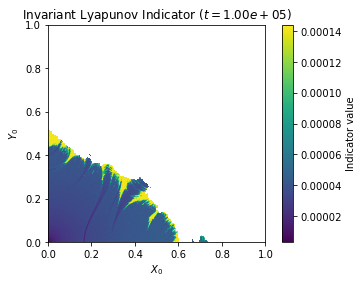

In [90]:
plt.figure()

plt.imshow(LEI_1_PP[-1], origin="lower", extent=[0,1,0,1])
plt.colorbar(label="Indicator value")
plt.title("Invariant Lyapunov Indicator $(t={:.2e})$".format(turn_samples[-1]))

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")

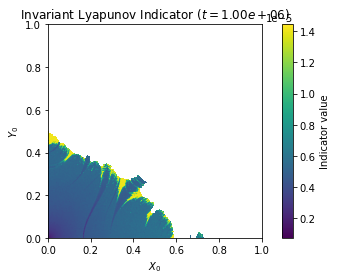

In [19]:
plt.figure()
for i, t in enumerate(turn_samples):
    plt.imshow(LEI_1[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("Invariant Lyapunov Indicator $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

  0%|          | 0/101 [00:00<?, ?it/s]

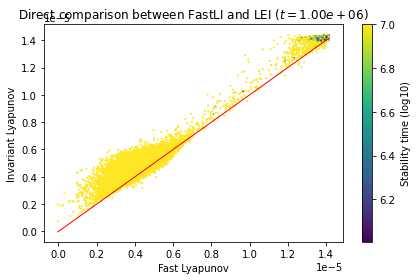

In [20]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        LI[i].flatten(),
        LEI_1[i].flatten(),
        s=1, label="data",
        c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis"
    )
    plt.plot(
        np.linspace(np.nanmin(LI[i]), np.nanmax(LI[i])),
        np.linspace(np.nanmin(LI[i]), np.nanmax(LI[i])),
        c="red", label="$x=y$", linewidth=1)
    plt.colorbar(label="Stability time $(\\log10)$")
    plt.xlabel("Fast Lyapunov")
    plt.ylabel("Invariant Lyapunov")
    plt.title("Direct comparison between FastLI and LEI $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_LI_LEI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

## Frequency/Tune Analysis

In [18]:
@njit(parallel=True)
def select_indices(l, c, r, data):
    p1 = np.empty(len(l), dtype=numba.int32)
    p2 = np.empty(len(l), dtype=numba.int32)
    vp1 = np.empty(len(l))
    vp2 = np.empty(len(l))
    for i in prange(data.shape[1]):
        if data[l[i], i] > data[r[i], i]:
            p1[i] = l[i]
            p2[i] = c[i]
            vp1[i] = data[p1[i], i]
            vp2[i] = data[p2[i], i]
        else:
            p1[i] = c[i]
            p2[i] = r[i]
            vp1[i] = data[p1[i], i]
            vp2[i] = data[p2[i], i]
    return p1, p2, vp1, vp2

@njit()
def interpolation(data, index):
    if np.any(np.isnan(data)):
        value = np.nan
    elif index == 0:
        value = 1
    else:
        if index == len(data) - 1:
            index -= 1
        cf1 = np.absolute(data[index - 1])
        cf2 = np.absolute(data[index])
        cf3 = np.absolute(data[index + 1])
        if cf3 > cf1:
            p1 = cf2
            p2 = cf3
            nn = index
        else:
            p1 = cf1
            p2 = cf2
            nn = index - 1            
        p3 = np.cos(2 * np.pi / len(data))
        value = (
            (nn / len(data)) + (1/np.pi) * np.arcsin(
                np.sin(2*np.pi/len(data)) * 
                ((-(p1+p2*p3)*(p1-p2) + p2*np.sqrt(p3**2*(p1+p2)**2 - 2*p1*p2*(2*p3**2-p3-1)))/(p1**2 + p2**2 + 2*p1*p2*p3))
            )
        )
    return np.absolute(1 - value)

In [19]:
full_track = h5py.File(os.path.join(inputdir, full_track_file), mode='r')

In [20]:
tune_x = np.empty((500,500))
tune_y = np.empty((500,500))
tune_x1 = np.empty((500,500))
tune_y1 = np.empty((500,500))
tune_x2 = np.empty((500,500))
tune_y2 = np.empty((500,500))

In [21]:
for i in tqdm(range(500)):
    data_x = full_track["coords/x"][:,i]
    data_px = full_track["coords/px"][:,i]
    data_y = full_track["coords/y"][:,i]
    data_py = full_track["coords/py"][:,i]
    for k in range(500):
        signal = data_x[:, k] + 1j * data_px[:, k]
        fft = np.absolute(np.fft.fft(signal * np.hanning(signal.shape[0])))
        value = np.argmax(fft)
        value = interpolation(fft, value)
        tune_x[i, k] = value
        
        signal = data_y[:, k] + 1j * data_py[:, k]
        fft = np.absolute(np.fft.fft(signal * np.hanning(signal.shape[0])))
        value = np.argmax(fft)
        value = interpolation(fft, value)
        tune_y[i, k] = value
        
        signal = data_x[:len(data_x)//2, k] + 1j * data_px[:len(data_x)//2, k]
        fft = np.absolute(np.fft.fft(signal * np.hanning(signal.shape[0])))
        value = np.argmax(fft)
        value = interpolation(fft, value)
        tune_x1[i, k] = value
        
        signal = data_y[:len(data_x)//2, k] + 1j * data_py[:len(data_x)//2, k]
        fft = np.absolute(np.fft.fft(signal * np.hanning(signal.shape[0])))
        value = np.argmax(fft)
        value = interpolation(fft, value)
        tune_y1[i, k] = value
        
        signal = data_x[len(data_x)//2:, k] + 1j * data_px[len(data_x)//2:, k]
        fft = np.absolute(np.fft.fft(signal * np.hanning(signal.shape[0])))
        value = np.argmax(fft)
        value = interpolation(fft, value)
        tune_x2[i, k] = value
        
        signal = data_y[len(data_x)//2:, k] + 1j * data_py[len(data_x)//2:, k]
        fft = np.absolute(np.fft.fft(signal * np.hanning(signal.shape[0])))
        value = np.argmax(fft)
        value = interpolation(fft, value)
        tune_y2[i, k] = value

  0%|          | 0/500 [00:00<?, ?it/s]

In [22]:
plt.figure()

plt.imshow(tune_x, origin="lower", extent=[0,1,0,1])
plt.colorbar(label="Tune $X$ [$2\\pi$ units]")
plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.title("Tune $X$ heatmap")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_tunex.png"), dpi=DPI)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
plt.figure()

plt.imshow(tune_y, origin="lower", extent=[0,1,0,1])
plt.colorbar(label="Tune $X$ [$2\\pi$ units]")
plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.title("Tune $Y$ heatmap")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_tuney.png"), dpi=DPI)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
plt.figure()

known_x_tune = 0.168
known_y_tune = 0.201

min_resonance = 2
max_resonance = 6
colors = ["red", "blue", "green", "orange", "cyan"]
alpha = 1.0

plt.axhline(known_y_tune, color="grey", label="known freq.")
plt.axvline(known_x_tune, color="grey")

x = np.linspace(0,1,100)

for i in list(range(min_resonance, max_resonance + 1))[::-1]:
    for j in range(1, i):
        nx = j
        ny = i - j
        for q in range(0, i+1):
            plt.plot(x, q/ny - nx / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - nx / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/ny - (-nx) / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - (-nx) / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
    for j in range(i+1):
        plt.axvline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1) if j != 0 else plt.axvline(
            j/i, color=colors[i-min_resonance], label="res {}".format(i), alpha=alpha, zorder=1)
        plt.axhline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1)

plt.scatter(tune_x.flatten(), tune_y.flatten(), s=0.5,
            marker="x", c=np.log10(long_tracking["stability_time"]), cmap='viridis', label="data", zorder=1)
plt.colorbar(label="Stability time (log10)")
        
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("tune $x$ [$2\\pi$ units]")
plt.ylabel("tune $y$ [$2\\pi$ units]")
plt.legend(ncol=2)
plt.title("Resonance Plot")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Resonance Plot')

In [25]:
plt.figure()

known_x_tune = 0.168
known_y_tune = 0.201

min_resonance = 2
max_resonance = 6
colors = ["red", "blue", "green", "orange", "cyan"]
alpha = 1.0

plt.axhline(known_y_tune, color="grey", label="known freq.")
plt.axvline(known_x_tune, color="grey")

x = np.linspace(0,1,100)

for i in list(range(min_resonance, max_resonance + 1))[::-1]:
    for j in range(1, i):
        nx = j
        ny = i - j
        for q in range(0, i+1):
            plt.plot(x, q/ny - nx / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - nx / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/ny - (-nx) / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - (-nx) / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
    for j in range(i+1):
        plt.axvline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1) if j != 0 else plt.axvline(
            j/i, color=colors[i-min_resonance], label="res {}".format(i), alpha=alpha, zorder=1)
        plt.axhline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1)

plt.scatter(tune_x.flatten(), tune_y.flatten(), s=0.5,
            marker="x",
            c=np.sqrt(
                initial_conditions["coords"]["x"][...]**2+
                initial_conditions["coords"]["px"][...]**2+
                initial_conditions["coords"]["y"][...]**2+
                initial_conditions["coords"]["py"][...]**2
            ),
            cmap='viridis', label="data", zorder=1)

plt.scatter(known_x_tune, known_y_tune, marker="*", color="grey")

plt.colorbar(label="Distance from center")
        
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("tune $x$ [$2\\pi$ units]")
plt.ylabel("tune $y$ [$2\\pi$ units]")
plt.legend(ncol=2)
plt.title("Resonance Plot")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Resonance Plot')

In [40]:
plt.figure()

known_x_tune = 0.168
known_y_tune = 0.201

min_resonance = 2
max_resonance = 6
colors = ["red", "blue", "green", "orange", "cyan"]
alpha = 1.0

plt.axhline(known_y_tune, color="grey", label="known freq.")
plt.axvline(known_x_tune, color="grey")

x = np.linspace(0,1,100)

for i in list(range(min_resonance, max_resonance + 1))[::-1]:
    for j in range(1, i):
        nx = j
        ny = i - j
        for q in range(0, i+1):
            plt.plot(x, q/ny - nx / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - nx / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/ny - (-nx) / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - (-nx) / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
    for j in range(i+1):
        plt.axvline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1) if j != 0 else plt.axvline(
            j/i, color=colors[i-min_resonance], label="res {}".format(i), alpha=alpha, zorder=1)
        plt.axhline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1)

plt.scatter(tune_x.flatten(), tune_y.flatten(), s=0.5,
            marker="x", c=np.log10(long_tracking["stability_time"]), cmap='viridis', label="data", zorder=1)

plt.scatter(known_x_tune, known_y_tune, marker="*", color="grey")

plt.colorbar(label="Stability time (log10)")
        
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("tune $x$ [$2\\pi$ units]")
plt.ylabel("tune $y$ [$2\\pi$ units]")
plt.legend(ncol=2)
plt.title("Resonance Plot")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Resonance Plot')

In [27]:
plt.figure()

plt.imshow(
    np.log10(np.sqrt(np.power(tune_x1 - tune_x2, 2) + np.power(tune_y1 - tune_y2, 2))),
    origin="lower", extent=[0,1,0,1]
)
plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.colorbar(label="Eucledian tune distance $(\\log10)$")

plt.title("Frequency map (time sample = {})".format(full_track.attrs["max_turns"]//2))

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_frequency_map_log.png"), dpi=DPI)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
plt.figure()

plt.imshow(
    (np.sqrt(np.power(tune_x1 - tune_x2, 2) + np.power(tune_y1 - tune_y2, 2))),
    origin="lower", extent=[0,1,0,1]
)
plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.colorbar(label="Eucledian tune distance")

plt.title("Frequency map (time sample = {})".format(full_track.attrs["max_turns"]//2))

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_frequency_map.png"), dpi=DPI)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|          | 0/101 [00:00<?, ?it/s]

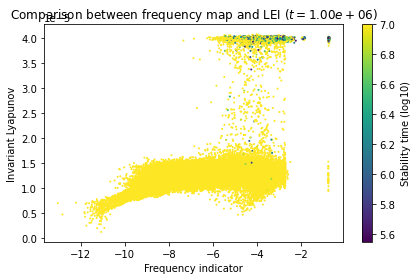

In [32]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(np.log10(np.sqrt(np.power(tune_x1 - tune_x2, 2) + np.power(tune_y1 - tune_y2, 2))), LEI_1[-10], s=1, c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis")
    
    plt.ylabel("Invariant Lyapunov")
    plt.xlabel("Frequency indicator")
    plt.colorbar(label="Stability time $(\\log10)$")
    
    plt.title("Comparison between frequency map and LEI $(t = {:.2e})$".format(t))
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vd_FM_LEI_{}.png".format(t)), dpi=DPI)
    plt.clf() if i != len(turn_samples)-1 else plt.show()

## New FFT data

In [17]:
fft_data = h5py.File(os.path.join(inputdir, fft_file), mode='r')

In [18]:
plt.figure()
plt.imshow(fft_data["14/tune_x"][0], origin="lower", extent=[0,1,0,1])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
plt.figure()
plt.imshow(fft_data["14/tune_y"][0], origin="lower", extent=[0,1,0,1])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
plt.figure()
data = np.sqrt(
    +np.power(fft_data["13/tune_x"][0] - fft_data["13/tune_x"][1], 2)
    +np.power(fft_data["13/tune_y"][0] - fft_data["13/tune_y"][1], 2)
)
plt.imshow(np.log10(data), origin="lower", extent=[0,1,0,1])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-20-adc4c54eb012>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(data), origin="lower", extent=[0,1,0,1])


In [21]:
plt.figure()
data = np.sqrt(
    +np.power(fft_data["13/tune_x"][0] - fft_data["13/tune_x"][1], 2)
    +np.power(fft_data["13/tune_y"][0] - fft_data["13/tune_y"][1], 2)
)
plt.imshow((data), origin="lower", extent=[0,1,0,1], vmax=0.00025)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
plt.figure()

known_x_tune = 0.168
known_y_tune = 0.201

min_resonance = 2
max_resonance = 6
colors = ["red", "blue", "green", "orange", "cyan"]
alpha = 1.0

plt.axhline(known_y_tune, color="grey", label="known freq.")
plt.axvline(known_x_tune, color="grey")

x = np.linspace(0,1,100)

for i in list(range(min_resonance, max_resonance + 1))[::-1]:
    for j in range(1, i):
        nx = j
        ny = i - j
        for q in range(0, i+1):
            plt.plot(x, q/ny - nx / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - nx / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/ny - (-nx) / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - (-nx) / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
    for j in range(i+1):
        plt.axvline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1) if j != 0 else plt.axvline(
            j/i, color=colors[i-min_resonance], label="res {}".format(i), alpha=alpha, zorder=1)
        plt.axhline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1)

plt.scatter(fft_data["14/tune_x"][0].flatten(), fft_data["14/tune_y"][0].flatten(), s=0.5,
            marker="x", c=np.log10(long_tracking["stability_time"]), cmap='viridis', label="data", zorder=1)

plt.scatter(known_x_tune, known_y_tune, marker="*", color="grey")

plt.colorbar(label="Stability time (log10)")
        
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("tune $x$ [$2\\pi$ units]")
plt.ylabel("tune $y$ [$2\\pi$ units]")
plt.legend(ncol=2)
plt.title("Resonance Plot")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Resonance Plot')

## Inversion error

In [ ]:
def make_REI_matrix(x0, px0, y0, py0, x, px, y, py):
    d_x = x - x0
    d_px = px - px0
    d_y = y - y0
    d_py = py - py0
    return np.transpose(np.array([
        [d_x  * d_x, d_x  * d_px, d_x  * d_y, d_x  * d_py],
        [d_px * d_x, d_px * d_px, d_px * d_y, d_px * d_py],
        [d_y  * d_x, d_y  * d_px, d_y  * d_y, d_y  * d_py],
        [d_py * d_x, d_py * d_px, d_py * d_y, d_py * d_py],
    ]), axes=(2,3,0,1))

In [29]:
inversion_pure = h5py.File(os.path.join(inputdir, inversion_file), mode='r')
inversion_gauss = h5py.File(os.path.join(inputdir, inversion_gauss_file), mode='r')
inversion_uniform = h5py.File(os.path.join(inputdir, inversion_uniform_file), mode='r')
inversion_gauss_forward = h5py.File(os.path.join(inputdir, inversion_gauss_forward_file), mode='r')
inversion_uniform_forward = h5py.File(os.path.join(inputdir, inversion_uniform_forward_file), mode='r')

In [31]:
RE = []
RE_U = []
RE_G = []
RE_U_F = []
RE_G_F = []

for t in tqdm(turn_samples):
    RE.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_pure[str(t)]["x"][...], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_pure[str(t)]["px"][...], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_pure[str(t)]["y"][...], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_pure[str(t)]["py"][...], 2)
    ))
    RE_U.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_uniform[str(t)]["x"][...], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_uniform[str(t)]["px"][...], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_uniform[str(t)]["y"][...], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_uniform[str(t)]["py"][...], 2)
    ))
    RE_G.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_gauss[str(t)]["x"], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_gauss[str(t)]["px"], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_gauss[str(t)]["y"], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_gauss[str(t)]["py"], 2)
    ))
    RE_U_F.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_uniform_forward[str(t)]["x"][...], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_uniform_forward[str(t)]["px"][...], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_uniform_forward[str(t)]["y"][...], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_uniform_forward[str(t)]["py"][...], 2)
    ))
    RE_G_F.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_gauss_forward[str(t)]["x"][...], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_gauss_forward[str(t)]["px"][...], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_gauss_forward[str(t)]["y"][...], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_gauss_forward[str(t)]["py"][...], 2)
    ))

RE = np.asarray(RE)
RE_U = np.asarray(RE_U)
RE_G = np.asarray(RE_G)
RE_U_F = np.asarray(RE_U_F)
RE_G_F = np.asarray(RE_G_F)

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
REI1 = []
REI1_U = []
REI1_G = []
REI1_U_F = []
REI1_G_F = []
REI2 = []
REI2_U = []
REI2_G = []
REI2_U_F = []
REI2_G_F = []
REI3 = []
REI3_U = []
REI3_G = []
REI3_U_F = []
REI3_G_F = []
REI4 = []
REI4_U = []
REI4_G = []
REI4_U_F = []
REI4_G_F = []

for t in tqdm(turn_samples):
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_pure[str(t)]["x"][...],
        inversion_pure[str(t)]["px"][...],
        inversion_pure[str(t)]["y"][...],
        inversion_pure[str(t)]["py"][...]
    )
    REI1.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4.append(v_faddeev_leverrier(matrix, [4])[:,:,1])
    
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_uniform[str(t)]["x"][...],
        inversion_uniform[str(t)]["px"][...],
        inversion_uniform[str(t)]["y"][...],
        inversion_uniform[str(t)]["py"][...]
    )
    REI1_U.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2_U.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3_U.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4_U.append(v_faddeev_leverrier(matrix, [4])[:,:,1])
    
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_gauss[str(t)]["x"][...],
        inversion_gauss[str(t)]["px"][...],
        inversion_gauss[str(t)]["y"][...],
        inversion_gauss[str(t)]["py"][...]
    )
    REI1_G.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2_G.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3_G.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4_G.append(v_faddeev_leverrier(matrix, [4])[:,:,1])
    
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_uniform_forward[str(t)]["x"][...],
        inversion_uniform_forward[str(t)]["px"][...],
        inversion_uniform_forward[str(t)]["y"][...],
        inversion_uniform_forward[str(t)]["py"][...]
    )
    REI1_U_F.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2_U_F.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3_U_F.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4_U_F.append(v_faddeev_leverrier(matrix, [4])[:,:,1])
    
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_gauss_forward[str(t)]["x"][...],
        inversion_gauss_forward[str(t)]["px"][...],
        inversion_gauss_forward[str(t)]["y"][...],
        inversion_gauss_forward[str(t)]["py"][...]
    )
    REI1_G_F.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2_G_F.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3_G_F.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4_G_F.append(v_faddeev_leverrier(matrix, [4])[:,:,1])

REI1 = np.asarray(REI1)
REI1_U = np.asarray(REI1_U)
REI1_G = np.asarray(REI1_G)
REI1_U_F = np.asarray(REI1_U_F)
REI1_G_F = np.asarray(REI1_G_F)

REI2 = np.asarray(REI2)
REI2_U = np.asarray(REI2_U)
REI2_G = np.asarray(REI2_G)
REI2_U_F = np.asarray(REI2_U_F)
REI2_G_F = np.asarray(REI2_G_F)

REI3 = np.asarray(REI3)
REI3_U = np.asarray(REI3_U)
REI3_G = np.asarray(REI3_G)
REI3_U_F = np.asarray(REI3_U_F)
REI3_G_F = np.asarray(REI3_G_F)

REI4 = np.asarray(REI4)
REI4_U = np.asarray(REI4_U)
REI4_G = np.asarray(REI4_G)
REI4_U_F = np.asarray(REI4_U_F)
REI4_G_F = np.asarray(REI4_G_F)

  0%|          | 0/61 [00:00<?, ?it/s]

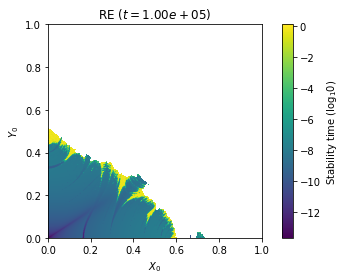

In [36]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.imshow(np.log10(RE[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_RE_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_sampling) - 1 else plt.show()
    

  0%|          | 0/61 [00:00<?, ?it/s]

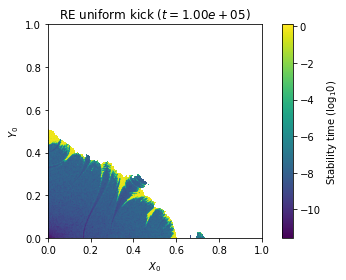

In [37]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.imshow(np.log10(RE_U[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE uniform kick $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_RE_unif_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_sampling) - 1 else plt.show()
    

  0%|          | 0/61 [00:00<?, ?it/s]

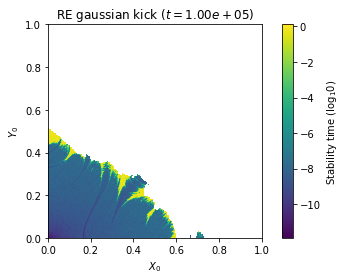

In [38]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.imshow(np.log10(RE_G[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE gaussian kick $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_RE_gauss_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_sampling) - 1 else plt.show()
    

  0%|          | 0/61 [00:00<?, ?it/s]

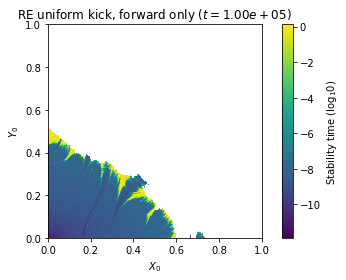

In [39]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.imshow(np.log10(RE_U_F[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE uniform kick, forward only $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_REF_unif_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_sampling) - 1 else plt.show()
    

  0%|          | 0/61 [00:00<?, ?it/s]

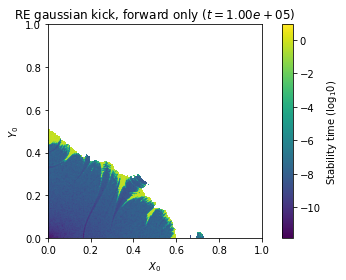

In [40]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.imshow(np.log10(RE_G_F[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE gaussian kick, forward only $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_REF_gauss_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_sampling) - 1 else plt.show()
    

In [32]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

  0%|          | 0/61 [00:00<?, ?it/s]

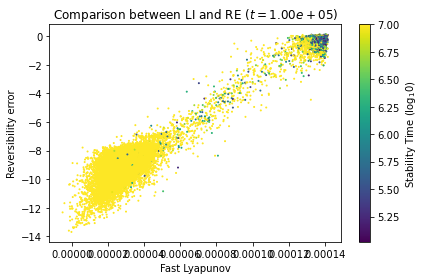

In [42]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    idx = find_nearest(turn_samples, t)[0]
    plt.scatter(LI[idx], np.log10(RE[i]), s=1, c=np.log10(long_tracking["stability_time"]), cmap="viridis")
    plt.colorbar(label="Stability Time $(\\log_10)$")
    plt.xlabel("Fast Lyapunov")
    plt.ylabel("Reversibility error")
    plt.title("Comparison between LI and RE $(t = {:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_RE_LI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_sampling) - 1 else plt.show()

  0%|          | 0/61 [00:00<?, ?it/s]

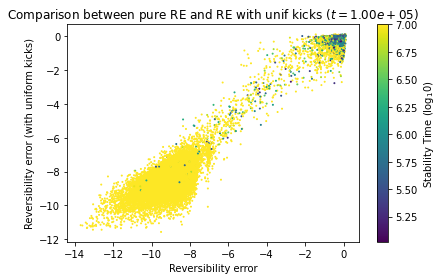

In [43]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.scatter(np.log10(RE[i]), np.log10(RE_U[i]), s=1, c=np.log10(long_tracking["stability_time"]), cmap="viridis")
    plt.colorbar(label="Stability Time $(\\log_10)$")
    plt.xlabel("Reversibility error")
    plt.ylabel("Reversibility error (with uniform kicks)")
    plt.title("Comparison between pure RE and RE with unif kicks $(t = {:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_RE_REU_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_sampling) - 1 else plt.show()

  0%|          | 0/61 [00:00<?, ?it/s]

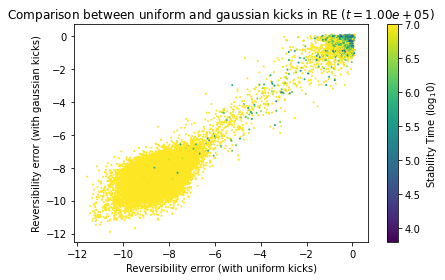

In [44]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.scatter(np.log10(RE_U[i]), np.log10(RE_G[i]), s=1, c=np.log10(long_tracking["stability_time"]), cmap="viridis")
    plt.colorbar(label="Stability Time $(\\log_10)$")
    plt.xlabel("Reversibility error (with uniform kicks)")
    plt.ylabel("Reversibility error (with gaussian kicks)")
    plt.title("Comparison between uniform and gaussian kicks in RE $(t = {:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_REU_REG_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_sampling) - 1 else plt.show()

## Comparisons with stability time

In [37]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        np.log10(long_tracking["stability_time"][...].flatten()),
        LI[i].flatten(),
        s=1, label="data",
    )
    plt.ylabel("Fast Lyapunov")
    plt.xlabel("Stability time [log10]")
    plt.title("Direct comparison between stability time and LI $(t={:.2e})$".format(t))
    
    #plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_time_LI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|          | 0/101 [00:00<?, ?it/s]

In [38]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        np.log10(long_tracking["stability_time"][...].flatten()),
        LEI_1[i].flatten(),
        s=1, label="data",
    )
    plt.ylabel("Invariant Lyapunov")
    plt.xlabel("Stability time [log10]")
    plt.title("Direct comparison between stability time and LI $(t={:.2e})$".format(t))
    
    #plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_time_LEI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|          | 0/101 [00:00<?, ?it/s]

In [39]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.scatter(
        np.log10(long_tracking["stability_time"][...].flatten()),
        RE[i].flatten(),
        s=1, label="data",
    )
    plt.ylabel("RE")
    plt.xlabel("Stability time [log10]")
    plt.title("Direct comparison between stability time and LI $(t={:.2e})$".format(t))
    
    #plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_time_RE_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
plt.figure()

for i, t in tqdm(enumerate(turn_sampling), total=len(turn_sampling)):
    plt.scatter(
        np.log10(long_tracking["stability_time"][...].flatten()),
        RE_U_F[i].flatten(),
        s=1, label="data",
    )
    plt.ylabel("RE")
    plt.xlabel("Stability time [log10]")
    plt.title("Direct comparison between stability time and LI $(t={:.2e})$".format(t))
    
    #plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_time_REUF_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

## MEGNO

In [ ]:
init_file = "henon_4d_init_eps_0_0_mu_0_0_id_basic_view.hdf5"

displacement_file = "henon_4d_displacement_eps_0_0_mu_0_0_id_basic_view_subid_1e-14.hdf5"
inversion_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_no_kick.hdf5"
inversion_gauss_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_gauss_kick.hdf5"
inversion_uniform_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_unif_kick.hdf5"
inversion_gauss_forward_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_gauss_kick_forward.hdf5"
inversion_uniform_forward_file = "henon_4d_inverse_tracking_eps_0_0_mu_0_0_id_basic_view_subid_unif_kick_forward.hdf5"
tracking_file = "henon_4d_long_track_eps_0_0_mu_0_0_id_basic_view.hdf5"
orto_displacement_file = "henon_4d_orto_displacement_eps_0_0_mu_0_0_id_basic_view_subid_1e-14.hdf5"
full_track_file = "henon_4d_verbose_track_eps_0_0_mu_0_0_id_basic_view.hdf5"
tracking_wkick_file = "henon_4d_long_track_wkick_eps_0_0_mu_0_0_id_basic_view_subid_1e-8.hdf5"
tracking_wkick_file2 = "henon_4d_long_track_wkick_eps_0_0_mu_0_0_id_basic_view_subid_1e-12.hdf5"
megno_file = "henon_4d_megno_eps_0_0_mu_0_0_id_basic_view.hdf5"
sali_file = "henon_4d_sali_eps_0_0_mu_0_0_id_basic_view.hdf5"
gali_file = "henon_4d_gali_eps_0_0_mu_0_0_id_basic_view.hdf5"

In [8]:
megno_data = h5py.File(os.path.join(inputdir, megno_file), mode='r')

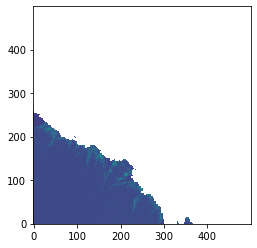

In [23]:
plt.figure()
plt.imshow((megno_data[str(turn_samples[50])]), origin="lower")


## SALI

In [27]:
sali_data = h5py.File(os.path.join(inputdir, sali_file), mode='r')

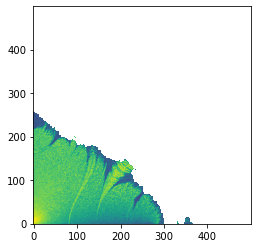

In [49]:
plt.figure()
plt.imshow(np.log10(sali_data[str(turn_samples[-2])]), origin="lower")

## GALI

In [36]:
gali_data = h5py.File(os.path.join(inputdir, gali_file), mode='r')

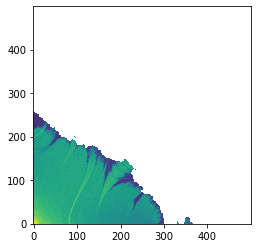

In [48]:
plt.figure()
plt.imshow(np.log10(gali_data["gali2"][str(turn_samples[-2])]), origin="lower")

# CONFUSION PLOTS

In [27]:
def make_confusion_data(stability_data, dynamic_data, value_sampling, reverse=False):
    bool_mask = np.logical_not(np.isnan(dynamic_data))
    dynamic_data = dynamic_data[bool_mask]
    stability_data = stability_data[bool_mask]
    valid_samples = np.count_nonzero(bool_mask)
    
    tp = np.empty(len(value_sampling))
    tn = np.empty(len(value_sampling))
    fp = np.empty(len(value_sampling))
    fn = np.empty(len(value_sampling))
    
    if not reverse:
        for i, v in enumerate(value_sampling):
            tp[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data>=v))
            fp[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data>=v))
            fn[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data<v))
            tn[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data<v))
    else:
        for i, v in enumerate(value_sampling):
            tp[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data<v))
            fp[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data<v))
            fn[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data>=v))
            tn[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data>=v))
    
    return tp/valid_samples, fp/valid_samples, tn/valid_samples, fn/valid_samples

In [34]:
value_sampling = np.linspace(np.nanmin(LI[-10]), np.nanmax(LI[-1]), 100)

tp, fp, tn, fn = make_confusion_data(
    long_tracking["stability_time"][...].flatten(),
    LI[-1].flatten(),
    value_sampling,
    reverse=True
)

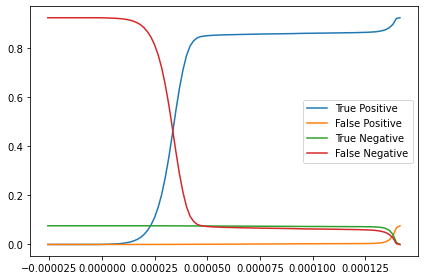

In [36]:
plt.figure()

plt.plot(value_sampling, tp, label="True Positive")
plt.plot(value_sampling, fp, label="False Positive")
plt.plot(value_sampling, tn, label="True Negative")
plt.plot(value_sampling, fn, label="False Negative")

plt.legend()
plt.tight_layout()

In [46]:
value_sampling = np.linspace(np.nanmin(LI[1]), np.nanmax(LI[-1]), 100)

tp, fp, tn, fn = make_confusion_data(
    long_tracking["stability_time"][...].flatten(),
    LI[-1].flatten(),
    value_sampling,
    reverse=True
)

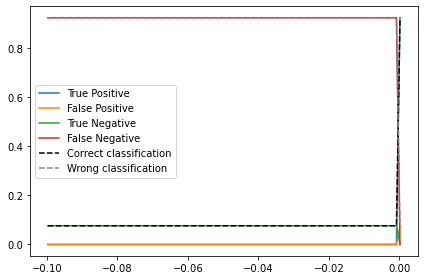

In [47]:
plt.figure()

plt.plot(value_sampling, tp, label="True Positive")
plt.plot(value_sampling, fp, label="False Positive")
plt.plot(value_sampling, tn, label="True Negative")
plt.plot(value_sampling, fn, label="False Negative")

plt.plot(value_sampling, tn + tp, "--", label="Correct classification", c="black")
plt.plot(value_sampling, fn + fp, "--", label="Wrong classification", c="grey")

plt.legend()
plt.tight_layout()